Simulation of a 2-D Spring lattice  
$F_{(i,j),(k,l)} = \frac{k\Delta z(r - r_0)}{r}$, $\Delta z = z_{(i,j)} - z_{(k,l)}$, $r = \sqrt{\Delta z^2 + d^2}$

$m_{(i,j)} \ddot z_{(i,j)} = -F_{(i-1,j),(i,j)} - F_{(i,j-1),(i,j)} + F_{(i,j),(i+1,j)} + F_{(i,j),(i,j+1)}$  
$z_{(0,:)} = 0$, $z_{(:,0)} = 0$

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from manim import *
from dataclasses import dataclass

In [17]:
@dataclass
class Params():
    N: int = 5          # Number of masses
    m: float = 0.2      # Mass of each mass (kg)
    k: float = 10.     # Spring constant (N/m)
    r_0: float = 0.1    # Spring equilibrium distance (m)
    d: float = 0.5      # In-plane distance between adjacent masses (m)
    t_max: float = 10.0     # Total time to simulate (s)
    dt: float = 0.01    # Time step (s)

class Drumhead():
    
    """
    N = number of masses in the system
    m = mass of each mass
    r_0 = spring equilibrium distance
    d = in-plane distance between adjacent masses
    """
    def __init__(self, p: Params):
        self.N = p.N
        self.m = p.m
        self.k = p.k
        self.r_0 = p.r_0
        self.d = p.d
    
    def dy_dt(self, t, z_arr):

        z = z_arr[:self.N**2].reshape((self.N, self.N))
        z_dot = z_arr[self.N**2:]

        z_ddot = np.zeros((self.N, self.N))
        
        #Boundary conditions: fixed ends
        z_ddot[0, :] = 0
        z_ddot[-1, :] = 0
        z_ddot[:, 0] = 0
        z_ddot[:, -1] = 0

        for i in range(1, self.N - 1):
            for j in range(1, self.N - 1):
                #z_ddot[i] = (self.k / self.m) * (z[i+1] - 2 * z[i] + z[i-1])
                r_up = np.sqrt(self.d**2 + (z[i-1, j] - z[i, j])**2)
                r_down = np.sqrt(self.d**2 + (z[i+1, j] - z[i, j])**2)
                r_left = np.sqrt(self.d**2 + (z[i, j-1] - z[i, j])**2)
                r_right = np.sqrt(self.d**2 + (z[i, j+1] - z[i, j])**2)

                F_up = self.k * (r_up - self.r_0) * (z[i-1, j] - z[i, j]) / r_up
                F_down = self.k * (r_down - self.r_0) * (z[i+1, j] - z[i, j]) / r_down
                F_left = self.k * (r_left - self.r_0) * (z[i, j-1] - z[i, j]) / r_left
                F_right = self.k * (r_right - self.r_0) * (z[i, j+1] - z[i, j]) / r_right

                z_ddot[i, j] = (F_up + F_down + F_left + F_right) / self.m

        z_ddot = z_ddot.flatten()

        return np.concatenate((z_dot, z_ddot))
    
    def solve_ode(self, t_pts, z_0, z_dot_0, 
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch.
        Specify smaller abserr and relerr to get more precision.
        """
        z_0 = z_0.flatten()
        z_dot_0 = z_dot_0.flatten()

        z_arr = np.concatenate((z_0, z_dot_0)) 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             z_arr, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        return solution.y

(5, 5, 1000)


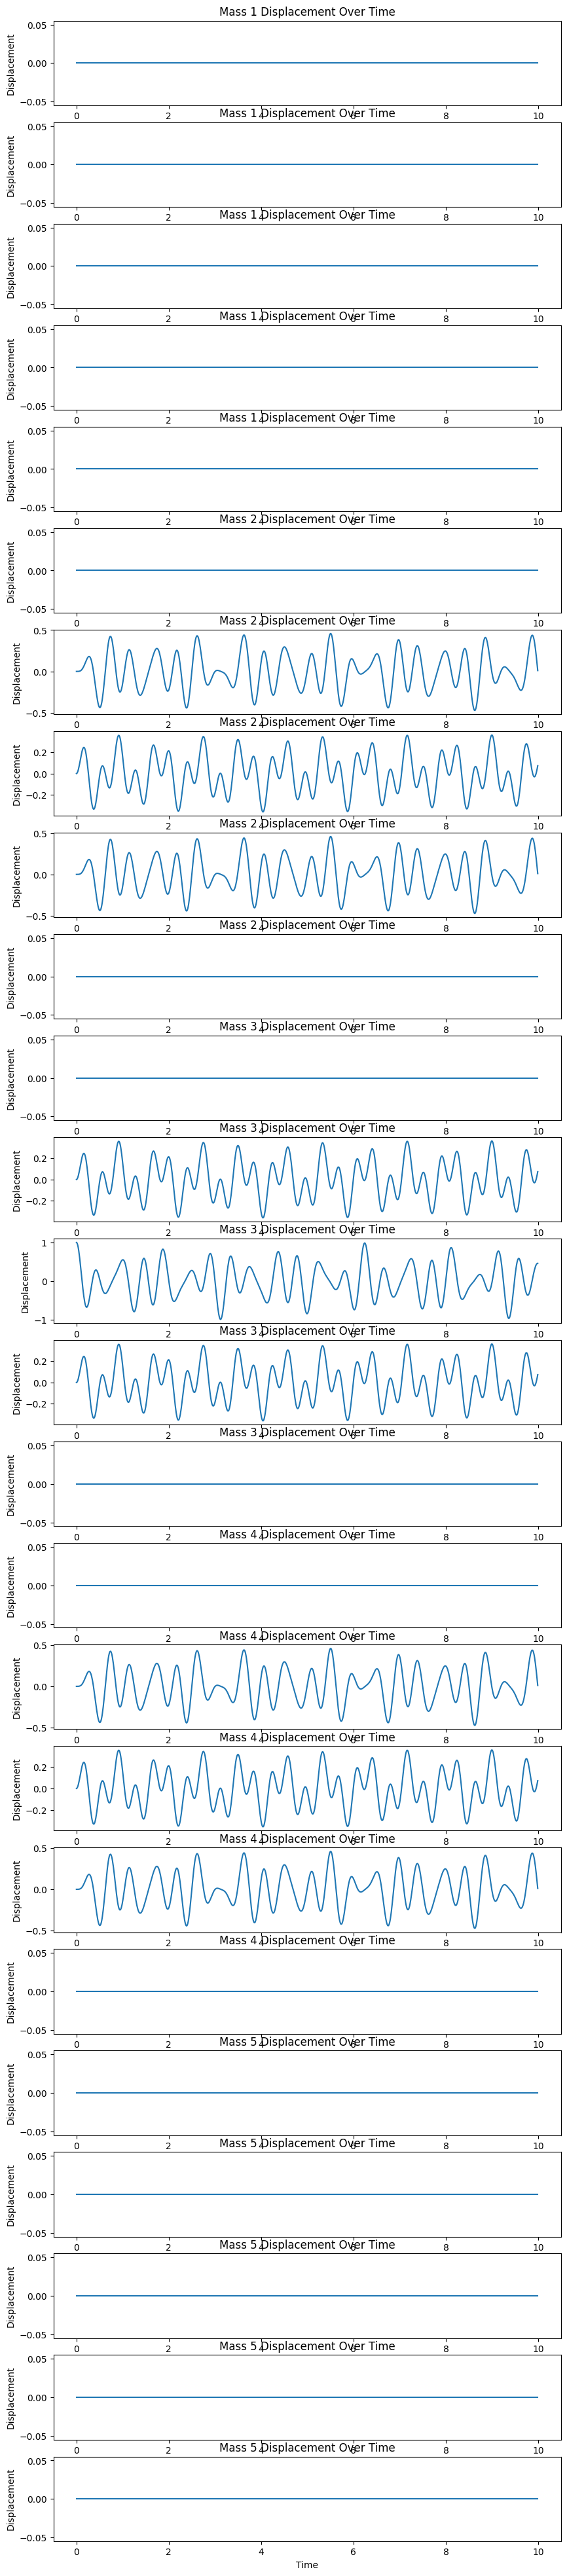

In [ ]:
# Create String instance
params = Params()

def solve_system(params):
    drumhead = Drumhead(params)

    t_pts = np.arange(0, params.t_max, params.dt)
    z_0 = np.zeros((params.N, params.N))
    z_dot_0 = np.zeros((params.N, params.N))
    z_0[params.N // 2, params.N // 2] = 1  # Initial displacement at the center mass
    solution = drumhead.solve_ode(t_pts, z_0, z_dot_0)
    return t_pts, solution

t_pts, sol = solve_system(params)
z = sol[:params.N**2, :]
z = z.reshape((params.N, params.N, -1))

# Plot results

fig, ax = plt.subplots(params.N**2, 1, figsize=(10, 2*params.N**2))

for i in range(params.N):
    for j in range(params.N):
        ind = i * params.N + j
        ax[ind].plot(t_pts, z[i][j][:])
        ax[ind].set_title(f'Mass {i+1} Displacement Over Time')
        ax[ind].set_xlabel('Time')
        ax[ind].set_ylabel('Displacement')


In [8]:
# -------------------------------
# Simple spring helper (zig-zag)
# -------------------------------
def spring_polyline(start, end, coils=6, amplitude=0.25, inset=0.35):
    """
    Returns a VMobject shaped like a planar coil spring from start -> end.
    Uses set_points_as_corners for a crisp zig-zag. Compatible with manim v0.19.
    """
    start = np.array(start, dtype=float)
    end   = np.array(end, dtype=float)
    vec = end - start
    L = np.linalg.norm(vec)
    if L < 1e-6:
        return Line(start, end, stroke_width=6)

    # Local frame
    xhat = vec / L
    up = np.array([0.0, 1.0, 0.0])
    yhat = up - np.dot(up, xhat) * xhat
    ny = np.linalg.norm(yhat)
    if ny < 1e-8:
        right = np.array([1.0, 0.0, 0.0])
        yhat = right - np.dot(right, xhat) * xhat
        yhat /= np.linalg.norm(yhat)
    else:
        yhat /= ny

    # Straight end segments + zig-zag body
    Lz = max(L - 2 * inset, 0.0)
    n_verts = 2 * coils + 1
    xs = np.linspace(inset, inset + Lz, n_verts)

    ys = np.zeros_like(xs)
    ys[1::2] =  amplitude
    ys[2::2] = -amplitude
    # Ensure the last zig-zag point is on the center line
    if n_verts > 0:
        ys[-1] = 0

    pts = [start, start + xhat * inset]
    for xi, yi in zip(xs, ys):
        pts.append(start + xhat * xi + yhat * yi)
    pts += [end - xhat * inset, end]

    pts = np.array(pts, dtype=float)

    spring = VMobject()
    spring.set_points_as_corners(pts)
    spring.set_stroke(width=6)
    spring.set_fill(opacity=0)
    return spring